In [ ]:
# Import libraries and mount drive

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 0) Data Loading and Exploration

In [ ]:
# Load datasets
dataDict = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/DataDictionary.csv')
top50ProdByTotalSales = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/Top50ProductsbyTotalSales-Timeseries.csv')
brandAvgRetailPrice = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandAverageRetailPrice.csv')
brandDetails = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandDetails.csv')
brandTotalSales = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandTotalSales.csv')
brandTotalUnits = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandTotalUnits.csv')

## dataDict Exploration

In [ ]:
dataDict = dataDict.loc[:,['Feature Name','Description']]
dataDict.head(5)

,Feature Name,Description
0,State,State where the sales occurred (for our datase...
1,Channel,Options between legal (licensed) and grey mark...
2,Category L1,Highest-level category for product. Options in...
3,Category L2,Next layer of categorization. Multiple product...
4,Category L3,Further detail on product-type


## top50ProdByTotalSales Exploration (Time Series)

In [ ]:
top50ProdByTotalSales.head(5)

,Products,Months,Total Sales ($)
0,Flower - Strain Blends - Flower (Gram),07/2020,"22,738,489.622206017"
1,Flower - Strain Blends - Flower (Gram),03/2021,"22,648,507.64839804"
2,Flower - Strain Blends - Flower (Gram),05/2021,"22,338,755.88508607"
3,Flower - Strain Blends - Flower (Gram),09/2020,"21,461,950.605336975"
4,Flower - Strain Blends - Flower (Gram),06/2021,"21,347,569.064233065"


## brandAvgRetailPrice Exploration (Time Series)

In [ ]:
# Show all null values
brandAvgRetailPrice.isnull().sum()

# Drop all rows containing NaN
brandAvgRetailPrice = brandAvgRetailPrice.dropna()
brandAvgRetailPrice.head(5)

,Brands,Months,ARP,vs. Prior Period
3,#BlackSeries,02/2021,11.873182,-0.127705
8,101 Cannabis Co.,02/2020,29.091388,-0.147753
9,101 Cannabis Co.,03/2020,32.293498,0.110071
10,101 Cannabis Co.,04/2020,32.934344,0.019844
11,101 Cannabis Co.,05/2020,34.441725,0.045769


In [ ]:
brandAvgRetailPrice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22570 entries, 3 to 27209
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            22570 non-null  object 
 1   Months            22570 non-null  object 
 2   ARP               22570 non-null  float64
 3   vs. Prior Period  22570 non-null  float64
dtypes: float64(2), object(2)
memory usage: 881.6+ KB


## brandDetails Exploration

In [ ]:
# The following columns were dropped because they had a majority of null values:
#   Category L5, Flavor, Item Weight, Pax Filter, Is Flavored 
# The following columns were dropped because they had >100 unique values
#   Category L4, Strain

brandDetails['Category L4'].value_counts()

Vape Cartridge     38488
Live Resin         20250
Rosin               7445
Vape Disposable     5813
Wax                 4367
                   ...  
Dab Rig                7
Soft                   6
Bandana                4
Flower                 4
Jar                    3
Name: Category L4, Length: 71, dtype: int64

In [ ]:
brandDetails.isnull().sum()

State                  0
Channel                0
Category L1            0
Category L2            0
Category L3            0
Brand                  0
Product Description    0
Total Sales ($)        0
Total Units            0
ARP                    0
Items Per Pack         0
Total THC              0
Total CBD              0
Contains CBD           0
Mood Effect            0
Generic Vendor         0
Generic Items          0
$5 Price Increment     0
dtype: int64

In [ ]:
brandDetails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144245 entries, 0 to 144976
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   State                144245 non-null  object 
 1   Channel              144245 non-null  object 
 2   Category L1          144245 non-null  object 
 3   Category L2          144245 non-null  object 
 4   Category L3          144245 non-null  object 
 5   Brand                144245 non-null  object 
 6   Product Description  144245 non-null  object 
 7   Total Sales ($)      144245 non-null  object 
 8   Total Units          144245 non-null  object 
 9   ARP                  144245 non-null  float64
 10  Items Per Pack       144245 non-null  int64  
 11  Total THC            144245 non-null  object 
 12  Total CBD            144245 non-null  object 
 13  Contains CBD         144245 non-null  object 
 14  Mood Effect          144245 non-null  object 
 15  Generic Vendor   

In [ ]:
brandDetails = brandDetails.drop(columns=['Flavor','Is Flavored','Pax Filter',
                           'Category L4','Category L5','Item Weight','Strain'])
# The following columns were dropped because they had a majority of null values:
#   Category L5, Flavor, Item Weight, Pax Filter, Is Flavored 
# The following columns were dropped because they had >100 unique values
#   Category L4, Strain

brandDetails = brandDetails.dropna()


## brandTotalSales Exploration (Time Series)

In [ ]:
brandTotalSales.head(5)

,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


## brandTotalUnits Exploration (Time Series)

In [ ]:
brandTotalUnits = brandTotalUnits.dropna()
brandTotalUnits.head(5)

,Brands,Months,Total Units,vs. Prior Period
3,#BlackSeries,02/2021,766.669135,0.071466
8,101 Cannabis Co.,02/2020,696.6584310000000,1.016883
9,101 Cannabis Co.,03/2020,943.3933280000000,0.354169
10,101 Cannabis Co.,04/2020,712.4981020000000,-0.244750
11,101 Cannabis Co.,05/2020,619.8410320000000,-0.130045


TypeError: ignored

# 1) Merge Datasets and Effectively Link Information

In [ ]:
# Load datasets
dataDict = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/DataDictionary.csv')
top50ProdByTotalSales = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/Top50ProductsbyTotalSales-Timeseries.csv')
brandAvgRetailPrice = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandAverageRetailPrice.csv')
brandDetails = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandDetails.csv')
brandTotalSales = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandTotalSales.csv')
brandTotalUnits = pd.read_csv('/content/drive/MyDrive/UCLA - Senior Year/CS 148/Project3.zip (Unzipped Files)/data/BrandTotalUnits.csv')

In [ ]:
# Goal: Merge all Time Series data based on Brand and Month (excludes top50)

ts_data = brandTotalSales.merge(brandTotalUnits,how='inner',left_on=['Brand','Months'],right_on=['Brands','Months'])
ts_data = ts_data.merge(brandAvgRetailPrice,how='inner',left_on=['Brands','Months'],right_on=['Brands','Months'])
ts_data = ts_data.drop(columns=['Brands'])
ts_data = ts_data.rename(columns={"Total Sales ($)":"Total Brand Sales ($)"})
ts_data.head(5)

,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y
0,09/2018,10x Infused,"1,711.334232",142.839336,-0.833098,11.980833,NaN
1,09/2018,1964 Supply Co.,"25,475.21594500000","2,395.534726000000",-0.184675,10.634459,NaN
2,09/2018,3 Bros Grow,"120,153.644757","10,018.989140000000",-0.577103,11.992592,NaN
3,09/2018,3 Leaf,"6,063.5297850000000","1,101.053215",-0.672014,5.507027,NaN
4,09/2018,350 Fire,"631,510.0481550000","64,128.91028600000",-0.216338,9.847509,NaN


In [ ]:
# Change data to correct dtype

# Remove all commas from df (necessary for pd.to_numeric)
ts_data = ts_data.replace(',','',regex=True)

# Convert 'Months' col to datetime dtype
ts_data['Months'] = pd.to_datetime(ts_data['Months'], format='%m/%Y')

# Convert Total Units and Total Brand Sales to float
ts_data['Total Units'] = pd.to_numeric(ts_data['Total Units'])
ts_data['Total Brand Sales ($)'] = pd.to_numeric(ts_data['Total Brand Sales ($)'])

# Clean brandDetails
brandDetails = brandDetails.replace(',','',regex=True)
brandDetails['Total THC'] = pd.to_numeric(brandDetails['Total THC'])
brandDetails['Total CBD'] = pd.to_numeric(brandDetails['Total CBD'])

# Display current state of df
ts_data.info()

# 2) Develop basic Time Series Feature Extraction Plan

## 2.1) Individual (Time Series) brand features

In [ ]:
# Augment features for a single brand (Time)
times = ts_data[ts_data.Brand == 'Wyld']

# Insert new column with the year
times['year'] = pd.DatetimeIndex(times['Months']).year

# Insert new column with the quarter of the fiscal year
bins = [0,3,6,9,12] # Creates a new bin for every 3 months
labels = [1,2,3,4] # Q1, Q2, ...
times['quarter'] = pd.cut(pd.DatetimeIndex(times['Months']).month,bins,labels=labels)

# Insert new column with length of time in market
times['length_in_market'] = times.loc[:,'Months'] - pd.DatetimeIndex(times['Months'])[0]

times.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,year,quarter,length_in_market
3654,2019-03-01,Wyld,1.430982e+04,876.645770,NaN,16.323377,NaN,2019,1,0 days
4238,2019-04-01,Wyld,1.965849e+05,11162.962026,11.733720,17.610457,0.078849,2019,2,31 days
4829,2019-05-01,Wyld,6.280397e+05,35304.441109,2.162641,17.789254,0.010153,2019,2,61 days
5455,2019-06-01,Wyld,1.064276e+06,59623.346049,0.688834,17.849994,0.003414,2019,2,92 days
6067,2019-07-01,Wyld,1.379979e+06,74048.747671,0.241942,18.636088,0.044039,2019,3,122 days


In [ ]:
# Augment features for a single brand (Sales)
sales = ts_data[ts_data.Brand == 'Wyld']

# Insert new column with last month's total sales
sales.loc[:,'Previous Month (Sales)'] = sales.loc[:,'Total Brand Sales ($)'].shift(1)

# Insert new column with average total sales over last 3 months
sales.loc[:,'Rolling Average (Sales)'] = (sales.loc[:,'Total Brand Sales ($)'].shift(1) + sales.loc[:,'Total Brand Sales ($)'].shift(2) + sales.loc[:,'Total Brand Sales ($)'].shift(3))/3

# Insert new column with market share of the brand over time (TODO)
sales.loc[:,'Market Share'] = sales.loc[:,'Total Brand Sales ($)'] / # Market Size at date

sales.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,Previous Month (Sales),Rolling Average (Sales)
3654,2019-03-01,Wyld,1.430982e+04,876.645770,NaN,16.323377,NaN,NaN,NaN
4238,2019-04-01,Wyld,1.965849e+05,11162.962026,11.733720,17.610457,0.078849,1.430982e+04,NaN
4829,2019-05-01,Wyld,6.280397e+05,35304.441109,2.162641,17.789254,0.010153,1.965849e+05,NaN
5455,2019-06-01,Wyld,1.064276e+06,59623.346049,0.688834,17.849994,0.003414,6.280397e+05,279644.784333
6067,2019-07-01,Wyld,1.379979e+06,74048.747671,0.241942,18.636088,0.044039,1.064276e+06,629633.627696


In [ ]:
# Augment features for a single brand (Units)
units = ts_data[ts_data.Brand == 'Wyld']

# Insert new column with last month's total units
units.loc[:,'Previous Month (Units)'] = units.loc[:,'Total Units'].shift(1)

# Insert new column with average total units over last 3 months
units.loc[:,'Rolling Average (Units)'] = (units.loc[:,'Total Units'].shift(1) + units.loc[:,'Total Units'].shift(2) + units.loc[:,'Total Units'].shift(3))/3

units.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,Previous Month (Units),Rolling Average (Units)
3654,2019-03-01,Wyld,1.430982e+04,876.645770,NaN,16.323377,NaN,NaN,NaN
4238,2019-04-01,Wyld,1.965849e+05,11162.962026,11.733720,17.610457,0.078849,876.645770,NaN
4829,2019-05-01,Wyld,6.280397e+05,35304.441109,2.162641,17.789254,0.010153,11162.962026,NaN
5455,2019-06-01,Wyld,1.064276e+06,59623.346049,0.688834,17.849994,0.003414,35304.441109,15781.349635
6067,2019-07-01,Wyld,1.379979e+06,74048.747671,0.241942,18.636088,0.044039,59623.346049,35363.583061


## 2.2) Augment (Time Series) features by brand, for every brand

In [ ]:
# Computation and creation of features for brand-by-brand augment

# Calculates total market value for each time (Later used for 'Market Share (%)')
dates = ts_data["Months"].unique()
totalShareByDate = list()
for date in dates:
  tot = 0
  for i in ts_data.index:
    if date == ts_data['Months'][i]:
      tot = tot + ts_data['Total Brand Sales ($)'][i]
  totalShareByDate.append(tot)

# Creates dataframe with market size at each time (Later used for 'Market Share (%)')
d = {'Time':dates,'Total Share ($)':totalShareByDate}
totShare = pd.DataFrame(data=d)

In [ ]:
# Augment features for every brand

# Create new dataframe to store augmented data
newCol = ['Months', 'Brand', 'Total Brand Sales ($)', 'Total Units',
       'vs. Prior Period_x', 'ARP', 'vs. Prior Period_y']
ts_data_new = pd.DataFrame(columns=newCol)

# Creates list which allow us to iterate through every
brands = ts_data["Brand"].unique()

# Perform brand-by-brand computations and append to new df
for brand in brands:
  times = ts_data[ts_data.Brand == brand]

  # Insert new column with the year
  times['year'] = pd.DatetimeIndex(times['Months']).year

  # Insert new column with the quarter of the fiscal year
  bins = [0,3,6,9,12] # Creates a new bin for every 3 months
  labels = [1,2,3,4] # Q1, Q2, ...
  times['quarter'] = pd.cut(pd.DatetimeIndex(times['Months']).month,bins,labels=labels)

  # Insert new column with length of time in market
  times['length_in_market'] = times.loc[:,'Months'] - pd.DatetimeIndex(times['Months'])[0]

  # Insert new column with last month's total units
  times.loc[:,'Previous Month (Units)'] = times.loc[:,'Total Units'].shift(1)

  # Insert new column with average total units over last 3 months
  times.loc[:,'Rolling Average (Units)'] = (times.loc[:,'Total Units'].shift(1) + times.loc[:,'Total Units'].shift(2) + times.loc[:,'Total Units'].shift(3))/3

  # Insert new column with market share ('Total Sales of 'brand' at _date_' / 'Total sales of industry at _date_')
  dates = ts_data["Months"].unique()
  temp = list()

  for i in times.index: # For every row in times
    for date in dates:  # For every date in the data
      if date == times['Months'][i]:  # If the date is the same as that of the current row, calculate market share
        val = totShare.loc[totShare.Time == times['Months'][i]]
        val = val.iloc[0]['Total Share ($)']
        temp.append(times['Total Brand Sales ($)'][i] / val)
        break
  times['Market Share (%)'] = temp

  # Insert new column with last month's total units
  times.loc[:,'Previous Month (Market Share)'] = times.loc[:,'Market Share (%)'].shift(1)

  # Insert new column with average market share over last 3 months
  times.loc[:,'Rolling Average (Market Share)'] = (times.loc[:,'Market Share (%)'].shift(1) + times.loc[:,'Market Share (%)'].shift(2) + times.loc[:,'Market Share (%)'].shift(3))/3

  # Append rows to ts_data_new (df including augmented data)
  ts_data_new = ts_data_new.append(times)

ts_data_new = ts_data_new.reset_index(drop=True)
ts_data_new.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,year,quarter,length_in_market,Previous Month (Sales),Rolling Average (Sales),Previous Month (Units),Rolling Average (Units),Market Share (%),Previous Month (Market Share),Rolling Average (Market Share)
0,2018-09-01,10x Infused,1711.334232,142.839336,-0.833098,11.980833,NaN,2018.0,3,0 days,NaN,NaN,NaN,NaN,0.000007,NaN,NaN
1,2018-09-01,1964 Supply Co.,25475.215945,2395.534726,-0.184675,10.634459,NaN,2018.0,3,0 days,NaN,NaN,NaN,NaN,0.000111,NaN,NaN
2,2018-10-01,1964 Supply Co.,13613.214128,1910.329288,-0.202546,7.126109,-0.329904,2018.0,4,30 days,25475.215945,NaN,2395.534726,NaN,0.000061,0.000111,NaN
3,2018-11-01,1964 Supply Co.,5402.873064,502.815600,-0.736791,10.745238,0.507869,2018.0,4,61 days,13613.214128,NaN,1910.329288,NaN,0.000024,0.000061,NaN
4,2018-12-01,1964 Supply Co.,11862.458357,2251.347983,3.477482,5.269047,-0.509639,2018.0,4,91 days,5402.873064,14830.434379,502.815600,1602.893205,0.000050,0.000024,0.000065


# 3) Run some basic statistics on your variables including correlations with labels and report findings

## 3.1) Histograms of all data

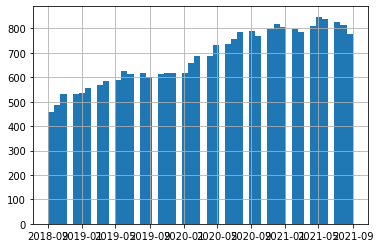

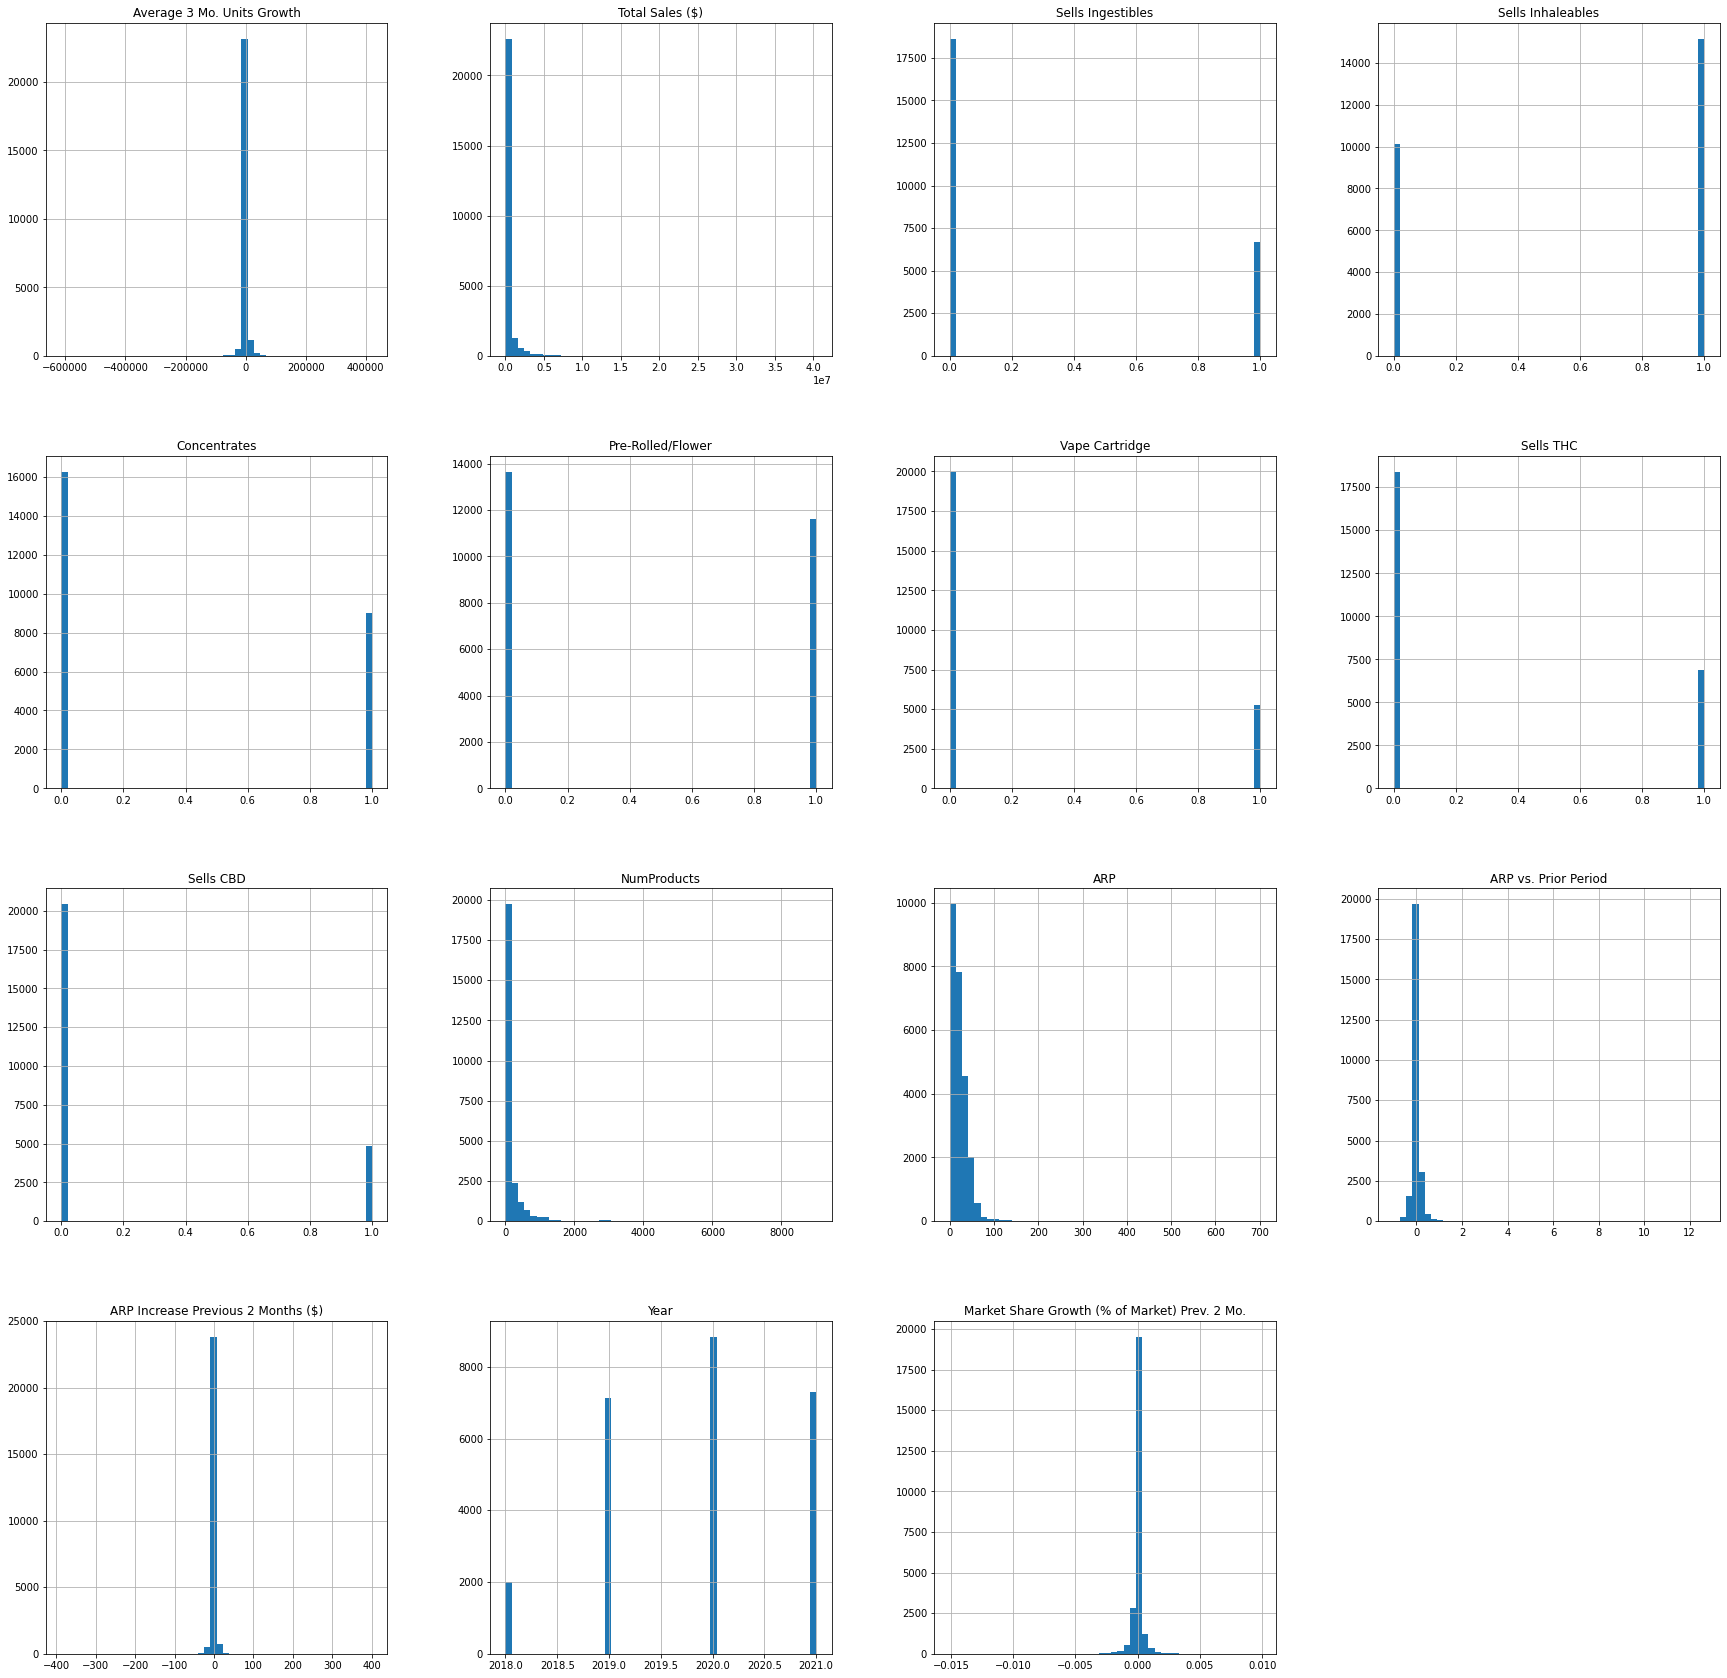

In [ ]:
data['Months'].hist(bins=50)
data.hist(bins=50, figsize=(30,30))
plt.show()

# Numeric:
#  - Right-skewed: Total Sales($), Total Units, Units Moved vs Prior Period, ARP, 
#      Units Moved Previous Month, 3 Prev. Month Units Moved Avg, Market Share, 
#      Previous Month (Market Shares), Rolling Average (Market Share), 
#      numProducts
#  - Narrow normal: ARP vs. Prior Period, Average 3 Mo. Units Growth
# Binary: Sells Inhaleables, Concentrates, Pre-Rolled/Flower, Vape Cartridge, 
#   Sells THC, Sells CBD
# Binary (Only 0): Sells Edibles
# Categorical (w/o gradient): Year

## 3.2) Correlation Matrix

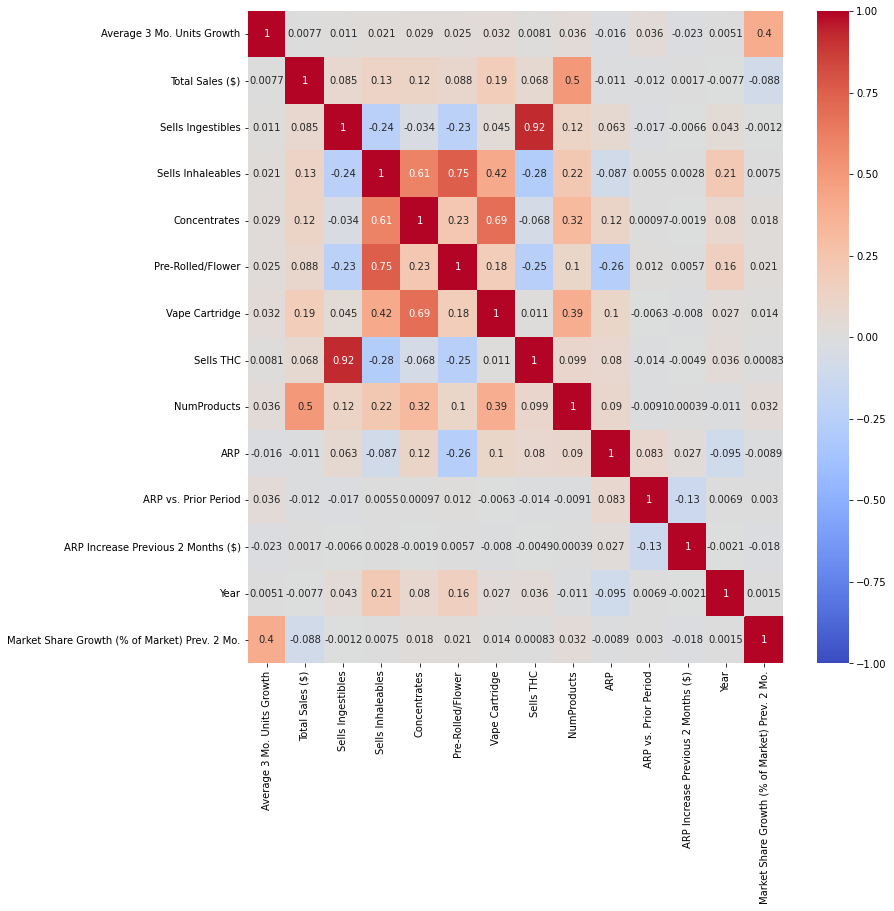

In [ ]:
# Load library for making heatmap from correlation matrix
import seaborn as sns

# Create correlation matrix across
corrMat = data.corr(method='pearson')

# Create heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrMat,vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True,ax=ax)

# Features with positive correlation: 
# - Total Units, Units Moved Previous Month, 3 Prev. Month Units Moved Avg, 
#   Market Share (%), Previous Month (Market Share), Rolling Average (Market 
#   Share)

# Features with mid positive correlation: 
# - NumProducts, Vape Cartridge

# Notable features with no correlation
# - The remaining features

In [ ]:
data.isna().sum()
print(data.shape)

print(brandTotalSales.shape)

(25279, 19)
(25279, 3)


# 4) Create additional data feature extraction plan and implement a comprehensive pipeline to execute it

## 4.1) Individual (Brand Level) brand features

In [ ]:
data = ts_data[ts_data.Brand == '101 Cannabis Co.']

# Feature Extraction from 'Category L1'
value = 0
value1 = 0
if 'Inhaleables' in brandDetails['Category L1'].values:
    value = 1
if 'Edibles' in brandDetails['Category L1'].values:
    value1 = 1

# Feature Extraction from 'Category L2'
value2 = 0
value3 = 0
if 'Concentrates' in brandDetails['Category L2'].values:
    value2 = 1
if 'Pre-Rolled' or 'Flower' in brandDetails['Category L2'].values:
    value3 = 1

# Feature Extraction from 'Category L4'
value4 = 0
if 'Vape Cartridge' in brandDetails['Category L4'].values:
    value4 = 1

# Feature Extraction from 'Total THC'
value5 = 1
if 0 in brandDetails['Total THC'].values:
    value5 = 0

# Feature Extraction from 'Total CBD'
value6 = 1
if 0 in brandDetails['Total CBD'].values:
    value6 = 0

# Add all augmented features to df
data.loc[:,'Inhaleables'] = value
data.loc[:,'Edible'] = value1
data.loc[:,'Concentrates'] = value2
data.loc[:,'Pre-Rolled_Flower'] = value3
data.loc[:,'Vape Cartridge'] = value4
data.loc[:,'Contains THC'] = value5
data.loc[:,'Contains CBD'] = value6

productcount = (brandDetails[brandDetails.Brand == '101 Cannabis Co.'].count()).iloc[0]
data.loc[:,'ProdCount'] = productcount

data.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,Inhaleables,Edible,Concentrates,Pre-Rolled_Flower,Vape Cartridge,Contains THC,Contains CBD,ProdCount
7908,2019-11-01,101 Cannabis Co.,4465.040321,131.067720,NaN,34.066667,NaN,1,0,1,1,1,0,0,77
9146,2020-01-01,101 Cannabis Co.,11790.663567,345.413448,NaN,34.134929,NaN,1,0,1,1,1,0,0,77
9765,2020-02-01,101 Cannabis Co.,20266.761007,696.658431,1.016883,29.091388,-0.147753,1,0,1,1,1,0,0,77
10424,2020-03-01,101 Cannabis Co.,30465.470533,943.393328,0.354169,32.293498,0.110071,1,0,1,1,1,0,0,77
11110,2020-04-01,101 Cannabis Co.,23465.657692,712.498102,-0.244750,32.934344,0.019844,1,0,1,1,1,0,0,77


## 4.2) Augment (Brand Level) features by brand, for every brand

In [ ]:
# Create new dataframe to store augmented data
newCol = ['Months', 'Brand', 'Total Brand Sales ($)', 'Total Units',
       'vs. Prior Period_x', 'ARP', 'vs. Prior Period_y']
ts_data_new_BL = pd.DataFrame(columns=newCol)

# Creates list which allow us to iterate through every
brands = ts_data_new["Brand"].unique()

# Perform brand-by-brand computations and append to new df
for brand in brands:

  data = ts_data_new[ts_data_new.Brand == brand]

  # Feature Extraction from 'Category L1'
  value = 0
  value1 = 0
  if 'Inhaleables' in brandDetails['Category L1'].values:
      value = 1
  if 'Edibles' in brandDetails['Category L1'].values:
      value1 = 1

  # Feature Extraction from 'Category L2'
  value2 = 0
  value3 = 0
  if 'Concentrates' in brandDetails['Category L2'].values:
      value2 = 1
  if 'Pre-Rolled' or 'Flower' in brandDetails['Category L2'].values:
      value3 = 1

  # Feature Extraction from 'Category L4'
  value4 = 0
  if 'Vape Cartridge' in brandDetails['Category L4'].values:
      value4 = 1

  # Feature Extraction from 'Total THC'
  value5 = 1
  if 0 in brandDetails['Total THC'].values:
      value5 = 0

  # Feature Extraction from 'Total CBD'
  value6 = 1
  if 0 in brandDetails['Total CBD'].values:
      value6 = 0

  # Add all augmented features to df
  data.loc[:,'Inhaleables'] = value
  data.loc[:,'Edible'] = value1
  data.loc[:,'Concentrates'] = value2
  data.loc[:,'Pre-Rolled_Flower'] = value3
  data.loc[:,'Vape Cartridge'] = value4
  data.loc[:,'Contains THC'] = value5
  data.loc[:,'Contains CBD'] = value6

  productcount = (brandDetails[brandDetails.Brand == '101 Cannabis Co.'].count()).iloc[0]
  data.loc[:,'ProdCount'] = productcount

  # Append rows to ts_data_new (df including augmented data)
  ts_data_new_BL = ts_data_new_BL.append(data)

ts_data_new_BL = ts_data_new_BL.reset_index(drop=True)
ts_data_new_BL.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Months,Brand,Total Brand Sales ($),Total Units,vs. Prior Period_x,ARP,vs. Prior Period_y,year,quarter,length_in_market,Previous Month (Sales),Rolling Average (Sales),Previous Month (Units),Rolling Average (Units),Market Share (%),Previous Month (Market Share),Rolling Average (Market Share),Inhaleables,Edible,Concentrates,Pre-Rolled_Flower,Vape Cartridge,Contains THC,Contains CBD,ProdCount
0,2018-09-01,10x Infused,1711.334232,142.839336,-0.833098,11.980833,NaN,2018.0,3,0 days,NaN,NaN,NaN,NaN,0.000007,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,77.0
1,2018-09-01,1964 Supply Co.,25475.215945,2395.534726,-0.184675,10.634459,NaN,2018.0,3,0 days,NaN,NaN,NaN,NaN,0.000111,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,77.0
2,2018-10-01,1964 Supply Co.,13613.214128,1910.329288,-0.202546,7.126109,-0.329904,2018.0,4,30 days,25475.215945,NaN,2395.534726,NaN,0.000061,0.000111,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,77.0
3,2018-11-01,1964 Supply Co.,5402.873064,502.815600,-0.736791,10.745238,0.507869,2018.0,4,61 days,13613.214128,NaN,1910.329288,NaN,0.000024,0.000061,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,77.0
4,2018-12-01,1964 Supply Co.,11862.458357,2251.347983,3.477482,5.269047,-0.509639,2018.0,4,91 days,5402.873064,14830.434379,502.815600,1602.893205,0.000050,0.000024,0.000065,1.0,0.0,1.0,1.0,1.0,0.0,0.0,77.0


## 4.3) Brand Details additional augments explanations

**State**: All 'California' (DROP)

**Channel**: All 'Licensed' (DROP)

**Category L1**: Majority 'Inhaleables' (Inhaleables vs other)

**Category L2**: Majority 'Concentrates'
- Split (Concentrates), (Pre-Rolled, Flower), other

**Category L3**: No large majority (DROP)

**Category L4**: Majority 'Vape Cartridge' (Vape Cartridge vs other)

**Category L5**: Too many null (DROP)

**Brand**: Use for linking

**Product Description**: All unique (DROP)

**Total Sales($)**: No correlation to ts_data (DROP)

**Total Units**: No correlation to ts_data (DROP)

**ARP**: No correlation to ts_data (DROP)

**Flavor**: Too many null (DROP)

**Items Per Pack**: Majority 0, meaningless (DROP)

**Item Weight**: Too many null (DROP)

**Total THC**: Majority 0, (0 vs other)

**Total CBD**: Majority 0, (0 vs other)

**Contains CBD**: 2 categories - THC Only, Contains CBD (one-hot-encode)

**Pax Filter**: Too many null (DROP)

**Strain**: >5000 (5824) unique string values (DROP)

**Mood Effect**: 2 categories - Not Mood Specific, Mood Specific (one-hot-encode)

**Generic Vendor**: 2 categories - Non-Generic Vendor, Generic Vendor (one-hot-encode)

**Generic Items**: 2 categories - Non-Generic Items, Generic Items (one-hot-encode)

**5 Dollar Price Increment**: Could convert to numeric feature at end of range and divide into >30 and <30 since $30 is roughly the median 

## 4.4) Comprehensive Feature Augmentation Pipeline

In [ ]:
def merge_clean_data(brandAvgRetailPrice,brandDetails,brandTotalSales,brandTotalUnits):
  # Merge BrandTotalSales.csv, BrandTotalUnits.csv, and BrandAverageRetailPrice.csv
  ts_data = brandTotalUnits.merge(brandTotalSales,left_on=['Brands','Months'],right_on=['Brand','Months'])
  ts_data = ts_data.merge(brandAvgRetailPrice,left_on=['Brands','Months'],right_on=['Brands','Months'])
  ts_data = ts_data.drop(columns=['Brands'])

  # === Change data to correct dtype ===

  # Convert 'Months' col to datetime dtype
  ts_data['Months'] = pd.to_datetime(ts_data['Months'], format='%m/%Y')

  # Convert Total Units and Total Sales to float (and Remove all commas from df)
  ts_data.loc[:, 'Total Units'] = ts_data['Total Units'].str.replace(',', '').str[:8]
  ts_data['Total Units'] = pd.to_numeric(ts_data['Total Units'])
  ts_data.loc[:, 'Total Sales ($)'] = ts_data['Total Sales ($)'].str.replace(',', '').str[:8]
  ts_data['Total Sales ($)'] = pd.to_numeric(ts_data['Total Sales ($)'])
  ts_data['ARP'] = pd.to_numeric(ts_data['ARP'])
  # ====================================
  return ts_data

In [ ]:
def augment_data(ts_data,brandDetails):

  # Clean brandDetails (make relevant columns numeric)
  #brandDetails = brandDetails.replace(',','',regex=True)
  #brandDetails['Total THC'] = pd.to_numeric(brandDetails['Total THC'])
  #brandDetails['Total CBD'] = pd.to_numeric(brandDetails['Total CBD'])

  # == Precomputation of Market Sizes ==
  # Calculates total market value for each time (Later used for 'Market Share (%)')
  dates = ts_data["Months"].unique()
  totalShareByDate = list()
  for date in dates:
    tot = 0
    for i in ts_data.index:
      if date == ts_data['Months'][i]:
        tot = tot + ts_data['Total Sales ($)'][i]
    totalShareByDate.append(tot)

  # Creates dataframe with market size at each time (Later used for 'Market Share (%)')
  d = {'Time':dates,'Total Share ($)':totalShareByDate}
  totShare = pd.DataFrame(data=d)
  # ====================================

  # Create new dataframe to store augmented data
  newCol = ['Months', 'Brand', 'Total Sales ($)', 'Total Units',
        'vs. Prior Period_x', 'ARP', 'vs. Prior Period_y']
  ts_data_new = pd.DataFrame(columns=newCol)

  # Creates list which allow us to iterate through every
  brands = ts_data["Brand"].unique()

  # Perform brand-by-brand computations and append to new df
  for brand in brands:
    data = ts_data[ts_data.Brand == brand]

    #CHECK FOR SIZE 0 DATAFRAME AFTER MERGES/COPY
    if len(data) == 0:
        continue

    # === Time Series Feature Extraction ===
    #grab datetime values
    datetimes = pd.DatetimeIndex(data['Months'])
    
    # Insert new column with ARP Increase over Previous 2 Months
    data.loc[:,'ARP Increase Previous 2 Months ($)'] = data.loc[:,'ARP'].shift(1) - data.loc[:,'ARP'].shift(2)

    # Insert new column with the year
    data.loc[:,'Year'] = datetimes.year

    # Insert new column with the quarter of the fiscal year
    bins = [0,3,6,9,12] # Creates a new bin for every 3 months
    labels = [1,2,3,4] # Q1, Q2, ...
    data.loc[:,'Quarter'] = pd.cut(datetimes.month, bins, labels=labels)

    # Insert new column with length of time in market
    data.loc[:,'Length_In_Market'] = data.loc[:,'Months'] - datetimes[0]

    # Insert new column with last month's total units
    data.loc[:,'Units Moved Previous Month'] = data.loc[:,'Total Units'].shift(1)

    # Insert new column with average total units over last 3 months
    data.loc[:,'3 Prev. Month Units Moved Avg.'] = (data.loc[:,'Total Units'].shift(1) + data.loc[:,'Total Units'].shift(2) + data.loc[:,'Total Units'].shift(3))/3

    # Insert new column with average unit movement growth
    data.loc[:,'Average 3 Mo. Units Growth'] = ((data.loc[:,'Total Units'].shift(1) - data.loc[:,'Total Units'].shift(2)) + (data.loc[:,'Total Units'].shift(2) - data.loc[:,'Total Units'].shift(3))) / 2

    # Insert new column with market share ('Total Sales of 'brand' at _date_' / 'Total sales of industry at _date_')
    dates = ts_data["Months"].unique()
    temp = list()

    for i in data.index: # For every row in data
      for date in dates:  # For every date in the data
        if date == data['Months'][i]:  # If the date is the same as that of the current row, calculate market share
          totalMarket = totShare[totShare.Time == data.loc[i,'Months']]
          totalMarket = totalMarket.iloc[0]['Total Share ($)']
          temp.append(data.loc[i,'Total Sales ($)'] / totalMarket)
          break
    data['Market Share (%)'] = temp

    #Insert new column with % market share growth over previous 2 months
    data.loc[:, 'Market Share Growth (% of Market) Prev. 2 Mo.'] = data.loc[:,'Market Share (%)'].shift(1) - data.loc[:,'Market Share (%)'].shift(2)

    # Insert new column with last month's total units
    data.loc[:,'Previous Month (Market Share)'] = data.loc[:,'Market Share (%)'].shift(1)

    # Insert new column with average market share over last 3 months
    data.loc[:,'Rolling Average (Market Share)'] = (data.loc[:,'Market Share (%)'].shift(1) + data.loc[:,'Market Share (%)'].shift(2) + data.loc[:,'Market Share (%)'].shift(3))/3

    # === Brand Level Feature Extraction ===
    # Modified from Daniel's pipeline
    testdets = brandDetails[brandDetails.Brand == brand]

    # Feature Extraction from 'Category L1'
    value = 0
    value1 = 0
    if 'Inhaleables' in testdets['Category L1'].values:
        value = 1
    if 'Ingestibles' in testdets['Category L1'].values:
        value1 = 1

    # Feature Extraction from 'Category L2'
    value2 = 0
    value3 = 0
    if 'Concentrates' in testdets['Category L2'].values:
        value2 = 1
    if 'Pre-Rolled' in testdets['Category L2'].values or 'Flower' in testdets['Category L2'].values:
        value3 = 1

    # Feature Extraction from 'Category L4'
    value4 = 0
    if 'Vape Cartridge' in testdets['Category L4'].values:
        value4 = 1

    # Feature Extraction from 'Total THC' --> Are there any THC contents nonzero
    value5 = 0
    if np.any(testdets['Total THC'].values):
        value5 = 1

    # Feature Extraction from 'Total CBD' --> Are there any CBD contents nonzero
    value6 = 0
    if np.any(testdets['Total CBD'].values):
        value6 = 1

    # Add all augmented features to df
    data.loc[:,'Sells Inhaleables'] = value
    data.loc[:,'Sells Ingestibles'] = value1
    data.loc[:,'Concentrates'] = value2
    data.loc[:,'Pre-Rolled/Flower'] = value3
    data.loc[:,'Vape Cartridge'] = value4
    data.loc[:,'Sells THC'] = value5
    data.loc[:,'Sells CBD'] = value6

    #add a categorical for the majority product
    edibles_ct = 0
    inhaleables_ct = 0
    try:
        edibles_ct = testdets['Category L1'].value_counts()['Edibles']
    except KeyError:
        edibles_ct = 0
    try:
        inhaleables_ct = testdets['Category L1'].value_counts()['Inhaleables']
    except KeyError:
        edibles_ct = 0

    majority = np.nan
    if inhaleables_ct == edibles_ct:
        majority = 'Tie'
    elif inhaleables_ct > edibles_ct:
        majority = 'Inhaleables'
    else:
        majority = 'Edibles'

    data.loc[:, 'Product Majority'] = majority

    productcount = (testdets[testdets.Brand == brand].count()).iloc[0]
    data.loc[:,'NumProducts'] = productcount

    # Append rows to ts_data_new (df including augmented data)
    ts_data_new = ts_data_new.append(data)

  ts_data_new.rename(columns={"vs. Prior Period_x": "Units Moved vs. Prior Period", "vs. Prior Period_y": "ARP vs. Prior Period","Brand":"Brands"}, inplace = True)
  ts_data_new = ts_data_new.reset_index(drop=True)  
  return ts_data_new

### Shows that multiple rows with same brand and date do NOT exist

In [ ]:
# Shows that multiple rows with same brand and date do NOT exist
unit_sales = pd.merge(brandTotalUnits,brandTotalSales,how='inner',left_on=['Brands','Months'],right_on=['Brand','Months'])
usARP = pd.merge(unit_sales,brandAvgRetailPrice,how='inner',left_on=['Brands','Months'],right_on=['Brands','Months'])
ts_data = usARP.drop(columns=['Brands'])
twoCol = ts_data[['Months','Brand']]

brands = twoCol['Brand'].unique()
count = 0
for brand in brands:
  temp = twoCol[twoCol.Brand == brand]
  if temp.shape[0] != len(temp['Months'].unique()):
    count = count + 1

print(count)

0


# 5) Implement a single pipeline to execute this transformation

## 5.1) Single Pipeline to augment, impute, and drop features

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Add imputation and drop
def drops_and_imputation(data):
    newdata = data.drop(axis = 1, labels = ['Product Majority', 'Brands', 'Months', 'Sells CBD', '3 Prev. Month Units Moved Avg.', 'Total Units', 'Units Moved vs. Prior Period', 'Units Moved Previous Month', 'Market Share (%)', 'Previous Month (Market Share)', 'Rolling Average (Market Share)'])
    newdata['Average 3 Mo. Units Growth'].fillna(0, inplace = True)
    newdata['ARP'].fillna(data['ARP'].median(), inplace = True)
    newdata['ARP vs. Prior Period'].fillna(0, inplace = True)
    newdata['ARP Increase Previous 2 Months ($)'].fillna(0, inplace = True)
    newdata['Market Share Growth (% of Market) Prev. 2 Mo.'].fillna(0, inplace = True)
    
    #One-hot encode dummy variables
    quarter_dummies = pd.get_dummies(newdata.Quarter, prefix='quarter')
    #majority_dummies = pd.get_dummies(newdata['Product Majority'], prefix = 'majority')
    
    newdata = pd.concat(objs = [newdata, quarter_dummies], axis=1)
    newdata = newdata.drop(axis = 1, labels = ['Quarter'])
    
    #Fix length in market to reflect days as integers
    newdata['Length In Market (Days)'] = newdata['Length_In_Market'] / np.timedelta64(1, 'D')
    newdata = newdata.drop(axis = 1, labels = ['Length_In_Market'])
    return newdata

def pipeline(brandAvgRetailPrice,brandDetails,brandTotalSales,brandTotalUnits):
  merged_data = merge_clean_data(brandAvgRetailPrice,brandDetails,brandTotalSales,brandTotalUnits)
  augmented_data = augment_data(merged_data,brandDetails)
  data = drops_and_imputation(augmented_data)
  
  cols = ['Total Sales ($)', 'ARP', 'ARP vs. Prior Period',
       'Average 3 Mo. Units Growth', 'Sells Ingestibles',
       'Sells Inhaleables', 'Concentrates', 'Pre-Rolled/Flower',
       'Vape Cartridge', 'Sells THC', 'NumProducts', 
        'ARP Increase Previous 2 Months ($)', 'Year',
        'Market Share Growth (% of Market) Prev. 2 Mo.', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4', 'Length In Market (Days)']

  data_prepared = data[cols] # Align with partner's columns
  
  return (cols,data_prepared)

def sep_split_scale(data,splitVal):
  #6) SEPARATE TARGET
  target = data['Total Sales ($)']
  features = data.drop(axis = 1, labels = ['Total Sales ($)'])

  #7) TRAIN TEST SPLIT (NEED TO DO BEFORE STANDARD SCALING SO AS NOT TO INTRODUCE MEAN/VAR OF TEST SET INTO MODELING)
  #train test split with 15% test size
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = splitVal, random_state = 0)

  #8) PERFORM STANDARD SCALING
  pip = Pipeline([('std_scaler', StandardScaler())])
  x_train = pip.fit_transform(x_train)
  x_test = pip.transform(x_test)
  return (target, features, x_train, x_test, y_train, y_test)


## 5.2) Test that pipeline works properly and Prepare for ML

In [ ]:
# Test that pipeline() functions properly
data = pipeline(brandAvgRetailPrice,brandDetails,brandTotalSales,brandTotalUnits)
data_sss = sep_split_scale(data[1],0.15)
cols = data[0][1:]
target = data_sss[0]
features = data_sss[1]
x_train = data_sss[2]
x_test = data_sss[3]
y_train = data_sss[4]
y_test = data_sss[5]

print(cols)
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

['ARP', 'ARP vs. Prior Period', 'Average 3 Mo. Units Growth', 'Sells Ingestibles', 'Sells Inhaleables', 'Concentrates', 'Pre-Rolled/Flower', 'Vape Cartridge', 'Sells THC', 'NumProducts', 'ARP Increase Previous 2 Months ($)', 'Year', 'Market Share Growth (% of Market) Prev. 2 Mo.', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'Length In Market (Days)']
(21487, 18)
(3792, 18)
(21487,)
(3792,)


### Shows that 13 unique brands exist in brandTotalUnits that do not exist in brandTotalSales nor brandARP

In [ ]:
#print(len(brandTotalSales['Brand'].unique()))
#print(len(brandTotalUnits['Brands'].unique()))

#print(list(set(brandTotalSales['Brand']).symmetric_difference(set(brandTotalUnits['Brands']))))

sales_and_units = set.union(set(brandTotalSales['Brand']),set(brandTotalUnits['Brands']))
brands_final = list(sales_and_units.symmetric_difference(set(brandAvgRetailPrice['Brands'])))

sales_and_units = set(set(brandTotalSales['Brand']).symmetric_difference(set(brandTotalUnits['Brands'])))
sales_and_arp   = set(set(brandTotalSales['Brand']).symmetric_difference(set(brandAvgRetailPrice['Brands'])))
units_and_arp   = set(set(brandTotalUnits['Brands']).symmetric_difference(set(brandAvgRetailPrice['Brands'])))
saleUnits_and_unitARP = set(sales_and_units.symmetric_difference(units_and_arp))

sz_sales = 0
sz_units = 0
sz_arp = 0
for brand in brands_final:
  single_sales = brandTotalSales[brandTotalSales.Brand == brand]
  single_units = brandTotalUnits[brandTotalUnits.Brands == brand]
  single_arp   = brandAvgRetailPrice[brandAvgRetailPrice.Brands == brand]
  if len(single_sales) is not 0:
    sz_sales = sz_sales + len(single_sales)
  if len(single_units) is not 0:
    sz_units = sz_units + len(single_units)
  if len(single_arp) is not 0:
    sz_arp = sz_arp + len(single_arp)

print("Sales: "+str(sz_sales))
print("Units: "+str(sz_units))
print("ARP: "+str(sz_arp))
print(len(sales_and_units))
print(len(sales_and_arp))
print(len(units_and_arp))
print(len(saleUnits_and_unitARP))

Sales: 0
Units: 26
ARP: 0
13
0
13
0


# 6) Documentation of data strategy (See Report)

# 7) Implement a Basic Linear Regression Predictive Model

## 7.1) Define metric function

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def linear_regression_metrics(y_train,train_preds,y_test,test_preds):
  print("Training Metrics: ")
  regression_results(y_train,train_preds)

  print("\nTesting Metrics: ")
  regression_results(y_test,test_preds)
  print('\n')

## 7.2) Linear Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

train_preds = lin_reg.predict(x_train)
test_preds  = lin_reg.predict(x_test)

linear_regression_metrics(y_train,train_preds,y_test,test_preds)

# Creates zipped list of coefficient values and column names
coef_label = list(zip(lin_reg.coef_,list(cols)))
display(coef_label)

Training Metrics: 
explained_variance:  0.2848
r2:  0.2848
MAE:  392315.2094
MSE:  1736944175558.2632
RMSE:  1317931.7796

Testing Metrics: 
explained_variance:  0.2036
r2:  0.2032
MAE:  429841.603
MSE:  2564128836913.0254
RMSE:  1601289.7417




[(-76398.53782379642, 'ARP'),
 (-2799.215325120109, 'ARP vs. Prior Period'),
 (-27271.211674332044, 'Average 3 Mo. Units Growth'),
 (69624.36145089362, 'Sells Ingestibles'),
 (173107.61128388223, 'Sells Inhaleables'),
 (-153033.41879977135, 'Concentrates'),
 (-28304.89622998625, 'Pre-Rolled/Flower'),
 (33150.672824789006, 'Vape Cartridge'),
 (-33461.75171580869, 'Sells THC'),
 (797872.2871201896, 'NumProducts'),
 (1448.9716411456886, 'ARP Increase Previous 2 Months ($)'),
 (-121039.83470959627, 'Year'),
 (-54235.023148638444, 'Market Share Growth (% of Market) Prev. 2 Mo.'),
 (17020.693672313675, 'quarter_1'),
 (6022.491515525264, 'quarter_2'),
 (1673.5065665559516, 'quarter_3'),
 (-25332.171385981434, 'quarter_4'),
 (143338.41695065898, 'Length In Market (Days)')]

## 7.3) Interpretation of features

The features with the largest positive correlations are:
- NumProducts (797872)
- Sells Inhaleables (173107)
- Length in Market (Days) (143338)

The features with the largest negative correlations are:
- Concentrates (-153033)
- Year (-121039)
- ARP (-76398)

Another interesting observation is the negative correlation with Total Sales and quarter_4. This indicates that sales decrease during the months of October through December.

However, the low $R^2$ values of 0.2032 (Test) and 0.2848 (Train) indicate that the basic linear regression model may not be a good model for the data.

# 8) Implement Principle Component Analysis (PCA)

## 8.1) PCA Model

In [ ]:
from sklearn import decomposition

# First we create a PCA object with the 4 components as a parameter
pca = decomposition.PCA(.95)

data_pca = pca.fit(x_train)

pca.n_components_

14

It is interesting that this pca split requires 14 of the 18 columns in the training data to account for the variance of the data

In [ ]:
# Redefine training and testing data using 14 principle components
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [ ]:
# Re-run linear regression to compare against original results
lin_reg = LinearRegression()
lin_reg.fit(x_train_pca, y_train)

train_preds = lin_reg.predict(x_train_pca)
test_preds  = lin_reg.predict(x_test_pca)

linear_regression_metrics(y_train,train_preds,y_test,test_preds)

Training Metrics: 
explained_variance:  0.2822
r2:  0.2822
MAE:  384003.9128
MSE:  1743366166790.2632
RMSE:  1320365.9215

Testing Metrics: 
explained_variance:  0.2017
r2:  0.2012
MAE:  421769.7522
MSE:  2570457064391.503
RMSE:  1603264.5023




## 8.2) PCA Interpretations


We see slightly lower $R^2$ values for both training (0.2822 vs. 0.2848) and testing (0.2012 vs. 0.2032). This indicates that the dimensionality reduction slightly reduces the likelihood that these correlations are relevant.

# 9) Employ an Ensemble Method (XGBOOST)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## 9.1) XGBOOST Implementation and Results

In [ ]:
# xbg result function definition

def xgb_results(xgb_model,y_train,x_train,y_test,x_test):
  score = xgb_model.score(x_train, y_train)  
  print("Training score: ", score)

  scores = cross_val_score(xgb_model, x_train, y_train,cv=10)
  print("Mean cross-validation score: %.2f" % scores.mean())

  kfold = KFold(n_splits=10, shuffle=True)
  kf_cv_scores = cross_val_score(xgb_model, x_train, y_train, cv=kfold )
  print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
  return

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", booster = 'gbtree', max_depth = 4, random_state=42)

xgb_model.fit(x_train, y_train)

xgb_results(xgb_model,y_train,x_train,y_test,x_test)

Training score:  0.9421443939690299
Mean cross-validation score: 0.86
K-fold CV average score: 0.87


In [ ]:
train_pred_xgb = xgb_model.predict(x_train)
test_pred_xgb = xgb_model.predict(x_test)

linear_regression_metrics(y_train,train_pred_xgb,y_test,test_pred_xgb)

Training Metrics: 
explained_variance:  0.9421
r2:  0.9421
MAE:  167691.5797
MSE:  140515458603.385
RMSE:  374853.9164

Testing Metrics: 
explained_variance:  0.9129
r2:  0.9129
MAE:  187815.9574
MSE:  280303284539.4755
RMSE:  529436.7616




In [ ]:
coef_label = list(zip(xgb_model.feature_importances_,list(cols)))
display(coef_label)

[(0.18182631, 'ARP'),
 (0.010821149, 'ARP vs. Prior Period'),
 (0.053453285, 'Average 3 Mo. Units Growth'),
 (0.040381365, 'Sells Ingestibles'),
 (0.07717449, 'Sells Inhaleables'),
 (0.06880223, 'Concentrates'),
 (0.092980914, 'Pre-Rolled/Flower'),
 (0.05869802, 'Vape Cartridge'),
 (0.0, 'Sells THC'),
 (0.2972738, 'NumProducts'),
 (0.011655428, 'ARP Increase Previous 2 Months ($)'),
 (0.011855306, 'Year'),
 (0.052128766, 'Market Share Growth (% of Market) Prev. 2 Mo.'),
 (0.0, 'quarter_1'),
 (0.0018615152, 'quarter_2'),
 (0.004011691, 'quarter_3'),
 (0.0012660758, 'quarter_4'),
 (0.035809614, 'Length In Market (Days)')]

## 9.2) XGBOOST Results Interpretation

The high training score of 0.942 and high K-fold cross-validation score of 0.87 indicate that XGBOOST is an excellent method for predicting Total Sales Data from the given parameters.

Importance of an attribute ($a_x$)for XGBoost in a single decision tree indicates the amount that each split of $a_x$ improves the overall performance measure, weighted by number of observations that each node affects. 

The overall *feature importance* for $a_x$ is then averaged across all decision trees in the model and reported by the above call.

Using the method of feature importance, it appears that the 3 MOST important features are:
- NumProducts (0.297)
- ARP (0.182)
- Pre-Rolled/Flower (0.093)

Whereas, the 3 LEAST important features are:
- Sells THC (0)
- quarter_1 (0)
- quarters 2, 3, and 4 (0.0019,0.0040, 0.0013)

Given that the $R^2$ values for training (0.9421) and testing (0.9129) have high significance and the 10-fold validation was 0.87, there is a very high likelihood that the aforementioned most and least important features are indeed correct.

## 9.3) XGBOOST + PCA Implementation

In [ ]:
xgb_model_pca = xgb.XGBRegressor(objective="reg:squarederror", booster = 'gbtree', max_depth = 4, random_state=42)

xgb_model_pca.fit(x_train_pca, y_train)

xgb_results(xgb_model_pca,y_train,x_train_pca,y_test,x_test_pca)

Training score:  0.8907704013696589
Mean cross-validation score: 0.64
K-fold CV average score: 0.61


In [ ]:
train_pred_xgb_pca = xgb_model_pca.predict(x_train_pca)
test_pred_xgb_pca = xgb_model_pca.predict(x_test_pca)

linear_regression_metrics(y_train,train_pred_xgb_pca,y_test,test_pred_xgb_pca)

Training Metrics: 
explained_variance:  0.8908
r2:  0.8908
MAE:  207922.0359
MSE:  265288849215.235
RMSE:  515061.9858

Testing Metrics: 
explained_variance:  0.7818
r2:  0.7818
MAE:  243647.3766
MSE:  702159585172.8735
RMSE:  837949.6316




## 9.4) XGBOOST + PCA Results Interpretation

Given that all relevent validation metrics (training score, mean cross-validation score, 10-fold cross validation average score, $R^2$ for testing, and $R^2$ for training) noticeably decreased, we can assume that dimensionality reduction once again does not benefit this model.

## 11) GridSearch 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## 11.1) GridSearchCV Implementation (1)

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", booster = 'gbtree', max_depth = 4, random_state=42)

tuned_parameters = [
    {"objective": ["reg:squarederror"], "booster": ["gbtree"], "sampling_method": ["uniform", "gradient_based"], "lambda": [0,  0.01, 0.1], "alpha": [0,  0.01, 0.1], "max_depth": [4], "random_state": [42]},
    {"objective": ["reg:squarederror"], "booster": ["gblinear"], "lambda": [0,  0.01, 0.1], "alpha": [0,  0.01, 0.1], "updater": ["shotgun", "coord_descent"], "max_depth": [4], "random_state": [42]},
]

scores = ["explained_variance","r2"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, scoring=score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for explained_variance

Best parameters set found on development set:

{'alpha': 0, 'booster': 'gbtree', 'lambda': 0, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42, 'sampling_method': 'uniform'}

Grid scores on development set:

0.866 (+/-0.085) for {'alpha': 0, 'booster': 'gbtree', 'lambda': 0, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42, 'sampling_method': 'uniform'}
0.866 (+/-0.085) for {'alpha': 0, 'booster': 'gbtree', 'lambda': 0, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42, 'sampling_method': 'gradient_based'}
0.866 (+/-0.085) for {'alpha': 0, 'booster': 'gbtree', 'lambda': 0.01, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42, 'sampling_method': 'uniform'}
0.866 (+/-0.085) for {'alpha': 0, 'booster': 'gbtree', 'lambda': 0.01, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42, 'sampling_method': 'gradient_based'}
0.866 (+/-0.085) for {'alpha': 0, '

## 11.2) GridSearchCV Implementation (2)

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", booster = 'gbtree', max_depth = 4, random_state=42)

tuned_parameters = [
    {"objective" : ["reg:squarederror"], "booster": ["gblinear"], "lambda": [0,1], "max_depth": [3,4,5,6,10,15], "random_state": [42]},
]

scores = ["explained_variance","r2"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, scoring=score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for explained_variance

Best parameters set found on development set:

{'booster': 'gbtree', 'lambda': 0, 'max_depth': 10, 'objective': 'reg:squarederror', 'random_state': 42}

Grid scores on development set:

0.821 (+/-0.098) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 3, 'objective': 'reg:squarederror', 'random_state': 42}
0.866 (+/-0.085) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 4, 'objective': 'reg:squarederror', 'random_state': 42}
0.884 (+/-0.069) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 5, 'objective': 'reg:squarederror', 'random_state': 42}
0.899 (+/-0.082) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 6, 'objective': 'reg:squarederror', 'random_state': 42}
0.903 (+/-0.090) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 10, 'objective': 'reg:squarederror', 'random_state': 42}
0.885 (+/-0.106) for {'booster': 'gbtree', 'lambda': 0, 'max_depth': 15, 'objective': 'reg:squarederror', 'random_state': 42}
0.821 (+/-0.

## 11.3) GridSearchCV Interpretation

GridSearchCV Implementation (1) indicates that of the following parameters: 

Alpha, booster, lambda, and sampling_method

Only 'booster' had an effect on the model's performance. Having a booster function of gbtree resulted in expected_variance of 0.866 whereas the booster function of


# 12) Experiment with your own custom models (RandomForestRegressor())

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## 12.1) RFR Implementation

In [ ]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)

pred_vals_train = rfr.predict(x_train)
pred_vals_test = rfr.predict(x_test)

linear_regression_metrics(y_train, pred_vals_train, y_test, pred_vals_test)

Training Metrics: 
explained_variance:  0.9852
r2:  0.9852
MAE:  56643.4045
MSE:  35862418773.7543
RMSE:  189373.7542

Testing Metrics: 
explained_variance:  0.9374
r2:  0.9374
MAE:  146821.2366
MSE:  201606061554.6374
RMSE:  449005.6364




In [ ]:
attr_imp = list(zip(rfr.feature_importances_,list(cols)))
display(attr_imp)

[(0.14537820941682578, 'ARP'),
 (0.008226624720767062, 'ARP vs. Prior Period'),
 (0.16402215934558267, 'Average 3 Mo. Units Growth'),
 (0.010457133125098802, 'Sells Ingestibles'),
 (0.007347636257732498, 'Sells Inhaleables'),
 (0.037383872253735614, 'Concentrates'),
 (0.003034415031346863, 'Pre-Rolled/Flower'),
 (0.0423196389994581, 'Vape Cartridge'),
 (7.209593801233629e-06, 'Sells THC'),
 (0.4675752652747198, 'NumProducts'),
 (0.01002086085395213, 'ARP Increase Previous 2 Months ($)'),
 (0.005605861437571619, 'Year'),
 (0.059227133199782095, 'Market Share Growth (% of Market) Prev. 2 Mo.'),
 (0.0007070534895909355, 'quarter_1'),
 (0.0007478082693593548, 'quarter_2'),
 (0.0017329794093332502, 'quarter_3'),
 (0.0008914946567103062, 'quarter_4'),
 (0.035314644664631835, 'Length In Market (Days)')]

## 12.2) K-fold Cross Validation of RF Regression

In [ ]:
from sklearn.model_selection import cross_val_score

# Pipeline data
data_all = pipeline(brandAvgRetailPrice,brandDetails,brandTotalSales,brandTotalUnits)
cols = data_all[0]
data = data_all[1]
data.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Total Sales ($)                                25279 non-null  float64
 1   ARP                                            25279 non-null  float64
 2   ARP vs. Prior Period                           25279 non-null  float64
 3   Average 3 Mo. Units Growth                     25279 non-null  float64
 4   Sells Ingestibles                              25279 non-null  float64
 5   Sells Inhaleables                              25279 non-null  float64
 6   Concentrates                                   25279 non-null  float64
 7   Pre-Rolled/Flower                              25279 non-null  float64
 8   Vape Cartridge                                 25279 non-null  float64
 9   Sells THC                                      252

In [ ]:
target = data['Total Sales ($)']
features = data.drop(axis = 1, labels = ['Total Sales ($)'])

clf = RandomForestRegressor(random_state=0)

scores = cross_val_score(clf, features, target, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print()

scores_ev = cross_val_score(clf, X, y, cv=5,scoring='explained_variance')
print("%0.2f explained_variance with a standard deviation of %0.2f" % (scores_ev.mean(), scores_ev.std()))
print()

scores_mse = cross_val_score(clf, X, y, cv=5,scoring='neg_mean_squared_error')
print("%0.2f mse with a standard deviation of %0.2f" % (scores_mse.mean(), scores_mse.std()))
print()

In [ ]:
from sklearn.model_selection import StratifiedKFold

#bin total sales data into quartile categories so I can do a stratified split-->REMOVE BEFORE TRAINING/TESTING
(quartile_1, quartile_2, quartile_3, maximum) = np.percentile(data['Total Sales ($)'], q= [25,50,75,100])
print(f"Quartile 1 Monthly Total Sales: ${quartile_1}")
print(f"Quartile 2 Total Sales: ${quartile_2}")
print(f"Quartile 3 Total Sales: ${quartile_3}")
print(f"Maximum Total Sales: ${maximum}")
bins = [-1, quartile_1, quartile_2, quartile_3, maximum] # Creates bin edges for each quartile
labels = [1, 2, 3, 4]
data['Total Sales Quartile'] = pd.cut(data['Total Sales ($)'], bins=bins, labels=labels)

data.head()
data.info()

Quartile 1 Monthly Total Sales: $13903.195
Quartile 2 Total Sales: $62100.8
Quartile 3 Total Sales: $247326.95
Maximum Total Sales: $40363507.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Total Sales ($)                                25279 non-null  float64 
 1   ARP                                            25279 non-null  float64 
 2   ARP vs. Prior Period                           25279 non-null  float64 
 3   Average 3 Mo. Units Growth                     25279 non-null  float64 
 4   Sells Ingestibles                              25279 non-null  float64 
 5   Sells Inhaleables                              25279 non-null  float64 
 6   Concentrates                                   25279 non-null  float64 
 7   Pre-Rolled/Flower                              25

In [ ]:
#now perform kfold cross-validation, stratified by total sales quartile
num_splits = 10
kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

#arrays to hold metrics for CV of linreg and xgboost
rfreg_maes = []
rfreg_r2s = []

#array for averaged XGB feature importance 
inferences = []

for train_index, test_index in kfold.split(data, data['Total Sales Quartile']):
    #data finishes at step 5 of pipeline-> and now modified with added column for strat.
    
    #Step 6 & Step 7, split data, drop target
    train_set = data.loc[train_index].copy()
    test_set = data.loc[test_index].copy()
    
    cv_data_train = train_set.drop('Total Sales ($)', axis=1)
    cv_labels_train = train_set['Total Sales ($)']
    
    cv_data_test = test_set.drop('Total Sales ($)', axis=1)
    cv_labels_test = test_set['Total Sales ($)']
    
    #DON'T LEAK THE TARGET VIA CATEGORY
    #drop the total sales categories!!
    cv_data_train = cv_data_train.drop('Total Sales Quartile', axis=1)
    cv_data_test = cv_data_test.drop('Total Sales Quartile', axis=1)
    display(cv_data_test.head(2))
    
    #standardize data (Step 8 of pipeline, 1-7 already complete)
    pip = Pipeline([('std_scaler', StandardScaler())])
    cv_train_prep = pip.fit_transform(cv_data_train)
    cv_test_prep = pip.transform(cv_data_test)
    
    #CROSS-VALIDATE LINREG MODEL
    rfreg = RandomForestRegressor(random_state=0)
    rfreg.fit(cv_data_train, cv_labels_train)
    preds = rfreg.predict(cv_data_test)
    rfreg_maes.append(mean_absolute_error(cv_labels_test, preds))
    rfreg_r2s.append(r2_score(cv_labels_test, preds))
    
    inferences.append(rfreg.feature_importances_)
    
print('RFRegression CV Performance (Test Data):')
print(f'Mean mae: {np.mean(rfreg_maes)}')
print(f'Mean R2: {np.mean(rfreg_r2s)}')    
print()
print('maes in Context')
#Interpret the cross-validated errors in context of the data
mean_sales = np.mean(data['Total Sales ($)'])
print(f'RFR mae/ Average Total Sales : {np.mean(rfreg_maes)/mean_sales}')  

RFRegression CV Performance (Test Data):
Mean mae: 149881.76096132092
Mean R2: 0.9039933458141111

maes in Context
RFR mae/ Average Total Sales : 0.36612535876052776


In [ ]:
data.head(5)

,Total Sales ($),ARP,ARP vs. Prior Period,Average 3 Mo. Units Growth,Sells Ingestibles,Sells Inhaleables,Concentrates,Pre-Rolled/Flower,Vape Cartridge,Sells THC,NumProducts,ARP Increase Previous 2 Months ($),Year,Market Share Growth (% of Market) Prev. 2 Mo.,quarter_1,quarter_2,quarter_3,quarter_4,Length In Market (Days),Total Sales Quartile
0,25352.130,15.684913,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,0.000000,2020.0,0.000000,0,0,1,0,0.0,2
1,9739.423,13.611428,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,0.000000,2021.0,0.000000,1,0,0,0,153.0,1
2,9102.802,11.873182,-0.127705,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,-2.073485,2021.0,-0.000043,1,0,0,0,184.0,1
3,4465.040,34.066667,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,77.0,0.000000,2019.0,0.000000,0,0,0,1,0.0,1
4,11790.660,34.134929,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,1.0,77.0,0.000000,2020.0,0.000000,1,0,0,0,61.0,1
